# Assignment 2 - part 2

## Convolutional neural network

Use the training and evaluation pipeline developed in part 1 to train and evaluate two CNN models.
The first shall be composed of standard convolutional layers, non-linaerities, and pooling layers of your choice. The second shall include skip connections. For this you shall develop your own ResidualBlack as a new layer under the nn.Module super-class.

### Train and apply model

Train the two models. Try different values of the hyper-paramter settings. You shall achieve at least 93% test accuracy with your best model.

Describe briefly your two models and your hyper-parameter setups and comment your results.

**Compare the performance of the two models and the three feed forward models using suitable supportive tables and graphs, and complemented by relevant comments.**


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# **Load the Dataset**

In [2]:
# Load the FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


# **Visualize images**

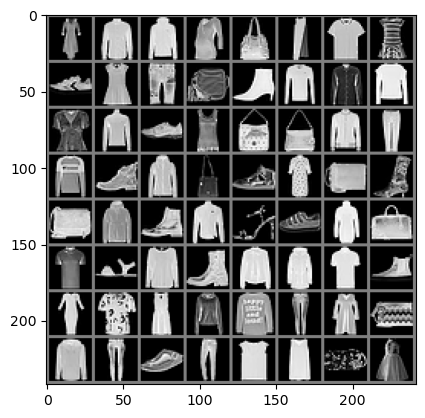

In [3]:
# Visualize some images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# **Standard CNN Model**

In [35]:

class StandardCNN(nn.Module):
    def __init__(self):
        super(StandardCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.pool(self.batchnorm2(F.relu(self.conv2(x))))
        x = self.pool(self.batchnorm3(F.relu(self.conv3(x))))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        
        x = x.view(-1, 64 * 7 * 7)  # Corrected view dimensions
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# **Residual Block for ResNet Model**

In [36]:
# Residual Block for ResNet Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Model
class ResNetCNN(nn.Module):
     def __init__(self):
         super(ResNetCNN, self).__init__()
         self.layer1 = ResidualBlock(1, 32, stride=1)
         self.layer2 = ResidualBlock(32, 64, stride=2)
         self.layer3 = ResidualBlock(64, 128, stride=2)
         self.fc1 = nn.Linear(128 * 7 * 7, 128)  # Correct input size based on the output from layer3
         self.fc2 = nn.Linear(128, 10)

     def forward(self, x):
         x = self.layer1(x)
         x = self.layer2(x)
         x = self.layer3(x)
         x = x.view(x.size(0), -1)  # Ensure the shape is (batch_size, 128 * 7 * 7)
         x = F.relu(self.fc1(x))
         x = self.fc2(x)
         return x



#  **Train the dataset**

In [37]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

# **Evaluate the Loss and Accuracy**

In [41]:
# Hyperparameters
num_epochs = 15
learning_rate = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Standard CNN Model Training
model_standard = StandardCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_standard.parameters(), lr=learning_rate)
train_losses_standard = train_model(model_standard, train_loader, criterion, optimizer, num_epochs)
accuracy_standard = evaluate_model(model_standard, test_loader)

 # ResNet Model Training
model_resnet = ResNetCNN().to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=learning_rate)
train_losses_resnet =train_model(model_resnet, train_loader, criterion, optimizer, num_epochs)
accuracy_resnet = evaluate_model(model_resnet, test_loader)


Epoch [1/15], Loss: 0.3210
Epoch [2/15], Loss: 0.2032
Epoch [3/15], Loss: 0.1589
Epoch [4/15], Loss: 0.1291
Epoch [5/15], Loss: 0.1034
Epoch [6/15], Loss: 0.0816
Epoch [7/15], Loss: 0.0644
Epoch [8/15], Loss: 0.0561
Epoch [9/15], Loss: 0.0443
Epoch [10/15], Loss: 0.0395
Epoch [11/15], Loss: 0.0314
Epoch [12/15], Loss: 0.0299
Epoch [13/15], Loss: 0.0307
Epoch [14/15], Loss: 0.0248
Epoch [15/15], Loss: 0.0227
Accuracy: 93.18%
Epoch [1/15], Loss: 0.3411
Epoch [2/15], Loss: 0.2131
Epoch [3/15], Loss: 0.1693
Epoch [4/15], Loss: 0.1352
Epoch [5/15], Loss: 0.1080
Epoch [6/15], Loss: 0.0798
Epoch [7/15], Loss: 0.0628
Epoch [8/15], Loss: 0.0470
Epoch [9/15], Loss: 0.0370
Epoch [10/15], Loss: 0.0328
Epoch [11/15], Loss: 0.0255
Epoch [12/15], Loss: 0.0254
Epoch [13/15], Loss: 0.0250
Epoch [14/15], Loss: 0.0187
Epoch [15/15], Loss: 0.0198
Accuracy: 92.42%


# **Comparison between Standard and Resnet Model**

          Model  Test Accuracy
0  Standard CNN          93.18
1    ResNet CNN          92.42


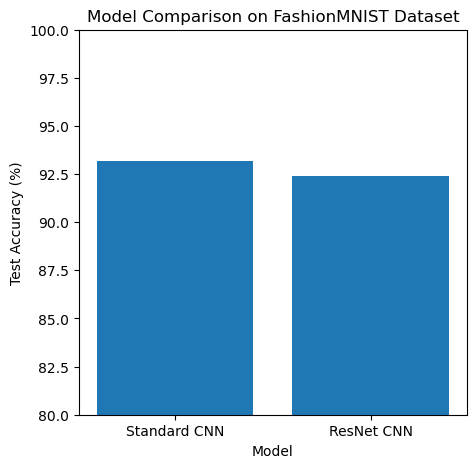

In [55]:
# Comparison
results = {
    'Model': ['Standard CNN', 'ResNet CNN'],
    'Test Accuracy': [accuracy_standard, accuracy_resnet]
}

df_results = pd.DataFrame(results)
print(df_results)

# Plotting the results
plt.figure(figsize=(5,5))
plt.bar(df_results['Model'], df_results['Test Accuracy'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.title('Model Comparison on FashionMNIST Dataset')
plt.ylim(80, 100)  # Ensuring the y-axis goes from 0 to 100 for better comparison
plt.show()

In [56]:
import pandas as pd 
results = pd.DataFrame({"Model Name":["Standard CNN","ResNet"],"Loss":["0.022","0.019"],
              "Test Accuracy":[93.18,92.42]})
results

,Model Name,Loss,Test Accuracy
0,Standard CNN,0.022,93.18
1,ResNet,0.019,92.42


**At first i tried with 3 covolution layers in standard CNN model, Eventhough by changing epocs and learning rate i didn't get required 93 % accuracy. so i add another convolutional layer with 15 epoch then i got the Accuracy of 93.18. In the ResNet model i got accuracy of 92.42%**